# Este experimento 2 corresponde a los siguientes hiperparámetros: 

- hidden_dim = 128
- latent_dim = 10
- learning_rate = 0.0001
- num_epochs = 100
- batch_size = 32


Epoch 1/100, Train Loss: 11503.809301403986, Test Loss: 9708.012700610307
Epoch 11/100, Train Loss: 1277.1487488677535, Test Loss: 1290.2250226039782
Epoch 21/100, Train Loss: 1204.2992597939312, Test Loss: 1232.5807897971292
Epoch 31/100, Train Loss: 1182.9400776296422, Test Loss: 1215.1168961205922
Epoch 41/100, Train Loss: 1171.3596315245697, Test Loss: 1200.425302681397
Epoch 51/100, Train Loss: 1160.6501341004303, Test Loss: 1190.6137280317587
Epoch 61/100, Train Loss: 1152.1016368036685, Test Loss: 1183.967584482369
Epoch 71/100, Train Loss: 1145.9973834493885, Test Loss: 1177.6327436285037
Epoch 81/100, Train Loss: 1139.2895790874095, Test Loss: 1173.447228540348
Epoch 91/100, Train Loss: 1134.398828478827, Test Loss: 1171.097557357595


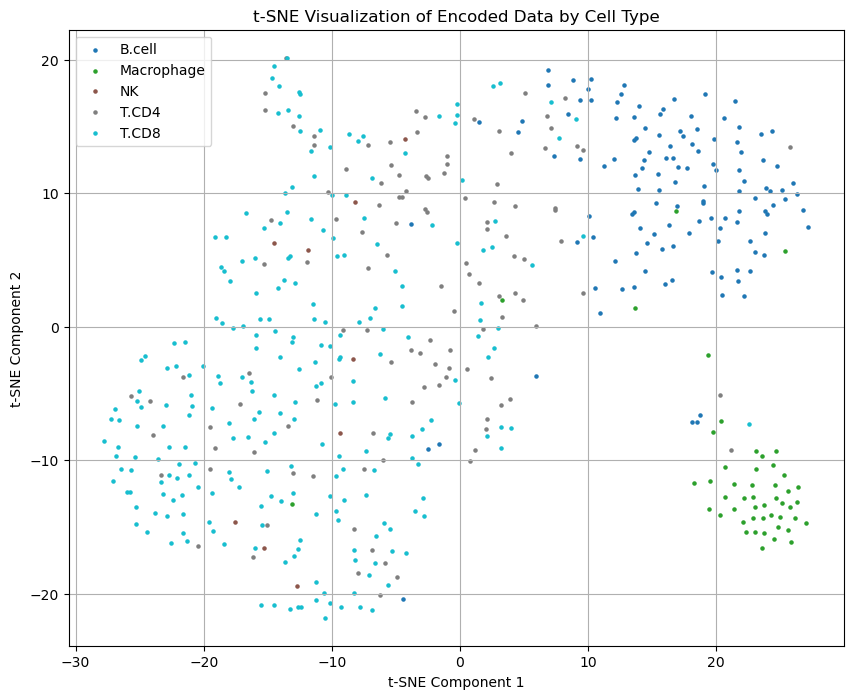

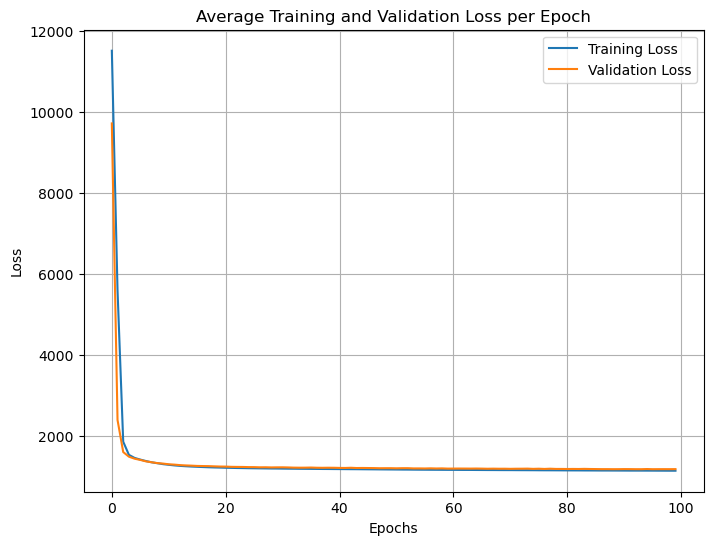

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Cargamos el dataset preprocesado en dataview.ipynb
reference_df = pd.read_csv('reference_preprocessed2.csv')

# Separamos las características de las etiquetas
labels = reference_df['label'].values
data = reference_df.drop(columns=['label']).values

# Normalizamos los datos al rango [0, 1] con MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Conversión los datos a tensores de PyTorch
data = torch.tensor(data, dtype=torch.float32)

# Codificamos las etiquetas de texto a números enteros
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# División de los datos en conjunto de entrenamiento (80%) y prueba (20%)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convertimos las etiquetas a tensores de PyTorch
train_labels = torch.tensor(train_labels, dtype=torch.int32)
test_labels = torch.tensor(test_labels, dtype=torch.int32)

# Modelo VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Función de pérdida (BCE + KLD)
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Definición de  hiperparámetros para Experimento 2
input_dim = data.shape[1]
hidden_dim = 128
latent_dim = 10
learning_rate = 0.0001
num_epochs = 100
batch_size = 32

# Conversión de los conjuntos de datos a DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Inicializamos el modelo y el optimizador
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Función de entrenamiento
def train_model(model, optimizer, train_loader, test_loader, num_epochs):
    model.train()
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Calcular la pérdida en el conjunto de prueba
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                recon_batch, mu, logvar = model(batch)
                loss = loss_function(recon_batch, batch, mu, logvar)
                test_loss += loss.item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        model.train()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}')
    
    return train_losses, test_losses

# Entrenamiento
train_losses, test_losses = train_model(model, optimizer, train_loader, test_loader, num_epochs)

# Evaluamos el modelo en datos de prueba
model.eval()
encoded_data_test = []
with torch.no_grad():
    for batch in test_loader:
        mu, logvar = model.encode(batch)
        z = model.reparameterize(mu, logvar)
        encoded_data_test.append(z.numpy())

encoded_data_test = np.concatenate(encoded_data_test)

# Aplicamos t-SNE para reducir a 2 dimensiones en datos de prueba
tsne = TSNE(n_components=2, random_state=42)
encoded_data_tsne = tsne.fit_transform(encoded_data_test)

# Visualizamos los datos codificados, que aparecerán coloreados por tipo celular:
plt.figure(figsize=(10, 8))
unique_labels = np.unique(test_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    indices = np.where(test_labels == label)
    plt.scatter(encoded_data_tsne[indices, 0], encoded_data_tsne[indices, 1], s=5, c=[colors[i]], label=label_encoder.inverse_transform([label])[0])
plt.title('t-SNE Visualization of Encoded Data by Cell Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de rendimiento por época para entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error

def calculate_mse(data, model):
    model.eval()
    mse_values = []
    with torch.no_grad():
        for i in range(len(data)):
            original = data[i].unsqueeze(0)
            recon, _, _ = model(original)
            mse = mean_squared_error(original.numpy(), recon.numpy())
            mse_values.append(mse)
    return mse_values

mse_values = calculate_mse(test_data, model)
average_mse = sum(mse_values) / len(mse_values)
print(f'Average MSE: {average_mse}')


Average MSE: 0.0033252614927221304


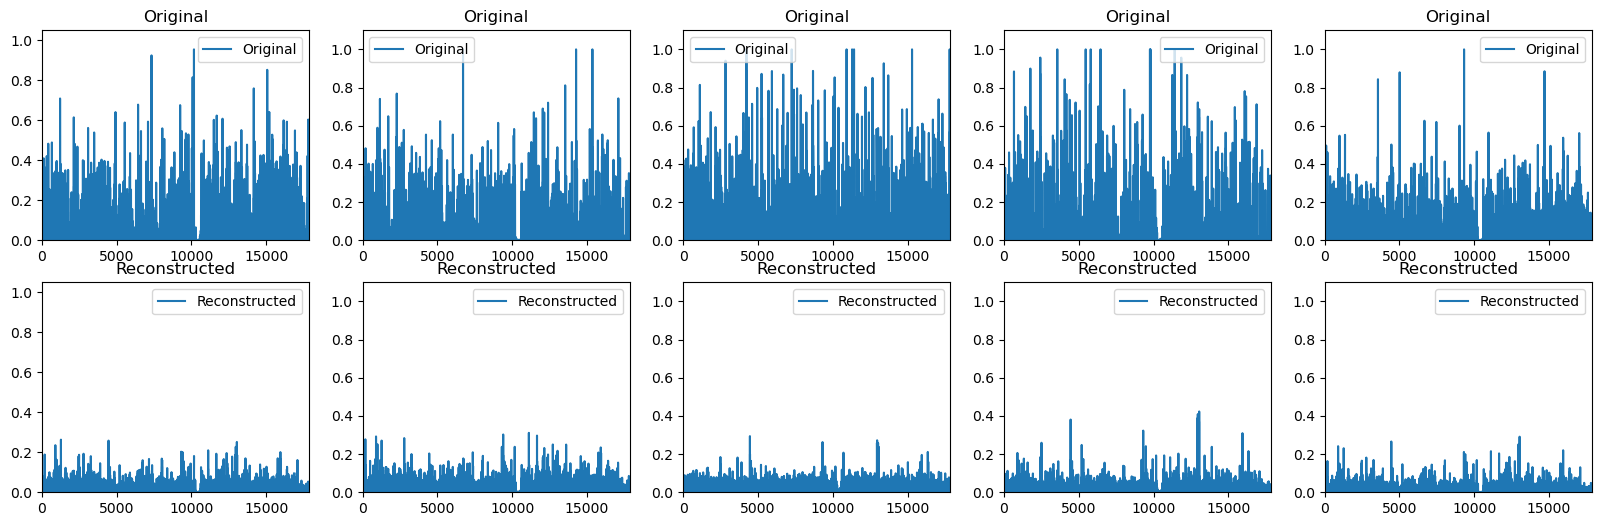

In [10]:
import random

def plot_reconstructions(data, model, n=5):
    model.eval()
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20, 6))
    with torch.no_grad():
        for i in range(n):
            idx = random.randint(0, len(data) - 1)
            original = data[idx].unsqueeze(0)
            recon, _, _ = model(original)
            axes[0, i].plot(original.numpy().flatten(), label='Original')
            axes[1, i].plot(recon.numpy().flatten(), label='Reconstructed')
            axes[0, i].set_title('Original')
            axes[1, i].set_title('Reconstructed')
            axes[0, i].set_ylim(0, max(original.max().item(), recon.max().item()) * 1.1)
            axes[1, i].set_ylim(0, max(original.max().item(), recon.max().item()) * 1.1)
            axes[0, i].set_xlim(0, original.shape[1])
            axes[1, i].set_xlim(0, original.shape[1])
            axes[0, i].legend()
            axes[1, i].legend()
    plt.show()

plot_reconstructions(test_data, model)


In [12]:
from scipy.stats import pearsonr

def calculate_correlation(data, model):
    model.eval()
    correlations = []
    with torch.no_grad():
        for i in range(len(data)):
            original = data[i].unsqueeze(0)
            recon, _, _ = model(original)
            corr, _ = pearsonr(original.numpy().flatten(), recon.numpy().flatten())
            correlations.append(corr)
    return correlations

correlations = calculate_correlation(test_data, model)
average_correlation = sum(correlations) / len(correlations)
print(f'Average Correlation: {average_correlation}')


Average Correlation: 0.3935174166469193


In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering(encoded_data, labels):
    silhouette_avg = silhouette_score(encoded_data, labels)
    db_score = davies_bouldin_score(encoded_data, labels)
    return silhouette_avg, db_score

silhouette_avg, db_score = evaluate_clustering(encoded_data_test, test_labels)
print(f'Silhouette Score: {silhouette_avg}, Davies-Bouldin Score: {db_score}')


Silhouette Score: 0.06864102929830551, Davies-Bouldin Score: 4.6721790081318915
